В этом ноутбуке берется переписанный код статьи и проверяется корректность его запуска, а именно, что итоговые метрики будут похожи на предоставленные в статье.

In [1]:
%cd ..

/workspace/TabDDPM_copy/TabDDPM


/venv/main/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm.tabddpm import *

### Подготовка

In [3]:
model_name = 'tabddpm'
dataname = 'adult'
model_short = 'TabDDPM'
save_cat=None

In [4]:
download_dataset(dataname)
process_data(dataname)

Start processing dataset adult from UCI.
Aready downloaded.
adult (32561, 15) (16281, 15) (32561, 15)
Numerical (32561, 6)
Categorical (32561, 8)
Processing and Saving adult Successfully!
adult
Total 48842
Train 32561
Test 16281
Num 6
Cat 9


In [5]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)
CONFIG.add_arg('save_cat', save_cat)


In [6]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")


CONFIG.add_arg('sample_save_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")
CONFIG.add_arg('real_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/real.csv")
CONFIG.add_arg('test_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/test.csv")
CONFIG.add_arg('info_path',
               f"data/{CONFIG.get_arg('dataname')}/info.json")

Device: cuda


In [7]:
CONFIG.get_all_args()

{'dataname': 'adult',
 'method': 'tabddpm',
 'device': 'cuda',
 'mode': 'train',
 'train': 1,
 'sample_save_path': 'synthetic/adult/tabddpm.csv',
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 76,
 'real_path': 'synthetic/adult/real.csv',
 'test_path': 'synthetic/adult/test.csv',
 'info_path': 'data/adult/info.json',
 'save_path': './synthetic/beijing_ON_QnSC_100k/initial_tabddpm_ON_QnSC_100k_mult_6.csv',
 'num_clusters': 25,
 'save_cat': None}

### Train

In [8]:
CONFIG.add_arg('mode', 'train')

In [9]:
tabddpm = TabDDPM(CONFIG)

In [12]:
tabddpm.train()

In [13]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    
cmap = get_cmap(10)

/tmp/ipykernel_46465/2983808042.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


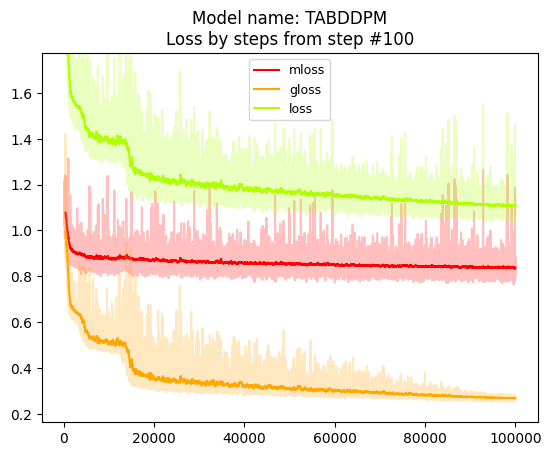

In [14]:
loss = pd.read_csv(f'./models/{model_name}/ckpt/{dataname}/loss.csv')
max_v, min_v = -np.inf, np.inf
window = 250

start_step = 100
for i, l in enumerate(loss.columns[1:]):
    plt.plot(loss['step'][start_step:], loss[l][start_step:], alpha=0.25, color=cmap(i))
    smoothed = np.convolve(loss[l][start_step:], np.ones(window)/window, 'valid')  
    plt.plot(loss['step'][start_step+window-1:], smoothed, label=l, color=cmap(i))

    max_v = np.max([np.quantile(loss[l][start_step:], 0.99), max_v])
    min_v = np.min([np.quantile(loss[l][start_step:], 0.01), min_v])

plt.ylim([min_v-0.1, max_v+0.1]) 
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}")
plt.savefig(f'./models/{model_name}/ckpt/{dataname}/loss_image.png')
plt.show()

In [15]:
tabddpm.sample(sample_save_path=CONFIG.get_arg('sample_save_path'))

No NaNs in numerical features, skipping
mlp
torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
Shape torch.Size([32561, 15])
(32561, 9)
Sampling time: 208.1098370552063


### Расчет метрик

In [16]:
from eval.base_metrics import calculate_base_metrics
from eval.similarity import calculate_similarity
from eval.mle import calculate_mle
from eval.alpha_beta import calculate_alpha_beta
from eval.detection import calculate_detection
from eval.dcr import calculate_DCR

In [17]:
overall_metrics = {}
overall_metrics[model_name] = {}

#### Метрики из starter_kit

In [18]:
overall_metrics[model_name]['base_metrics'] = calculate_base_metrics(make_binary=True, value=' >50K')

/venv/main/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TABDDPM: ADULT Dataset
Original Logistic: 0.657
Synthetic Logistic: 0.656
Original Tree: 0.660
Synthetic Tree: 0.637 

TABDDPM Accuracy Loss: ADULT
Logistic: 0.176%
Tree: 3.450% 



#### Метрики из статьи TabSyn

In [19]:
overall_metrics[model_name]['similarity'] = calculate_similarity()

CALCULATING COLUMN-WISE DENSITY ESTIMATION & PAIR-WISE COLUMN CORRELATION...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 73.00it/s]|
Column Shapes Score: 98.91%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:01<00:00, 54.28it/s]|
Column Pair Trends Score: 97.96%

Overall Score (Average): 98.44%

Error rate (%) of column-wise density estimation TABDDPM: 1.087 ± 0.796
Error rate (%) of pair-wise column correlation score TABDDPM: 2.041 ± 1.270


DONE! 

DRAW COLUMN VALUES DISTRIBUTIONS...


DONE!


#### MLE

In [23]:
overall_metrics[model_name]['mle'] = calculate_mle()

100%|██████████| 36/36 [00:10<00:00,  3.45it/s]


Saving scores to  eval/mle/adult/tabddpm.json
ROC - AUC обучения на синтетических данных TABDDPM: 0.897 ± 0.007


#### Detection: classifier two sample tests (C2ST)

In [24]:
overall_metrics[model_name]['detection'] = calculate_detection()

adult, tabddpm: 0.9502201675894645


#### DCR

In [25]:
overall_metrics[model_name]['DCR'] = calculate_DCR()

n_clusters: 25
n_clusters: 25
n_clusters: 25
DCR Score, a value closer to 0.5 is better
adult-tabddpm, DCR Score = 0.5146647830226344


#### Alpha precision & Beta recall

In [26]:
overall_metrics[model_name]['quality'] = calculate_alpha_beta()

=========== All Features ===========
Data shape:  (32561, 110)
alpha precision: 0.951938, beta recall: 0.498005


### Табличка

In [27]:
final_metrics_table = []
for m in overall_metrics.keys():
    # Сбор таблички результатов
    tmp = pd.DataFrame([{'Model':'TabDDPM', 'Type':m, 'Data':dataname}])
    tmp.columns = pd.MultiIndex.from_tuples([('', i) for i in tmp.columns])
    result = [tmp]
    
    for metric_group in overall_metrics[m].keys():
        tmp = pd.DataFrame([overall_metrics[m][metric_group]])
        tmp.columns = pd.MultiIndex.from_tuples([(metric_group, i) for i in tmp.columns])
        result.append(tmp)
    result = pd.concat(result, axis = 1)
    final_metrics_table.append(result)
    
final_metrics_table = pd.concat(final_metrics_table)

In [29]:
pd.set_option('display.max_columns', None)
final_metrics_table.round(4)

base_metrics                                   \
     Model     Type   Data Original Logistic Synthetic Logistic Original Tree   
0  TabDDPM  tabddpm  adult            0.6571             0.6559        0.6599   

                                                                  \
  Synthetic Tree Accuracy Loss Logistic, % Accuracy Loss Tree, %   
0         0.6371                    0.1758                3.4503   

              similarity                              \
  Column Shapes Score, % Column Pair Trends Score, %   
0                98.9128                     97.9587   

                              \
  Overall Score (Average), %   
0                    98.4358   

                                                       \
  Error rate (%) of column-wise density estimation, %   
0                                              1.0872   

                                                           \
  Error rate (%) of column-wise density estimation std, %   
0                                                  0.7956   

                                                           \
  Error rate (%) of pair-wise column correlation score, %   
0                                                  2.0413   

                                                               \
  Error rate (%) of pair-wise column correlation score std, %   
0                                                      1.2698   

                                         mle  \
  ROC - AUC обучения на синтетических данных   
0                                     0.8967   

                                                  detection     DCR  \
  ROC - AUC обучения на синтетических данных, std     Score   Score   
0                                          0.0066    0.9502  0.5147   

          quality              
  alpha precision beta recall  
0          0.9519       0.498

In [30]:
import os
if not os.path.exists(f'./eval/total/{dataname}'):
    os.makedirs(f'./eval/total/{dataname}')
final_metrics_table.to_csv(f'./eval/total/{dataname}/{model_short}_final_metrics_table.csv', index=False)